In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cv2
from PIL import Image
import random

# Thư viện deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Thư viện đánh giá
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


2025-05-20 16:06:09.854719: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747757170.038012      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747757170.090656      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Xem một số ảnh ở các lớp

image_size:  (300, 300, 3)


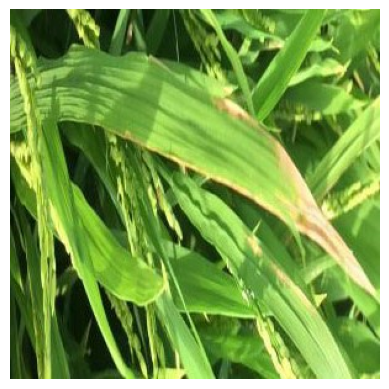

In [2]:
first_image = cv2.imread('/kaggle/input/rice-leaf-disease-image/Bacterialblight/BACTERAILBLIGHT3_003.jpg')
print('image_size: ', first_image.shape)
plt.imshow(cv2.cvtColor(first_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

image_size:  (300, 300, 3)


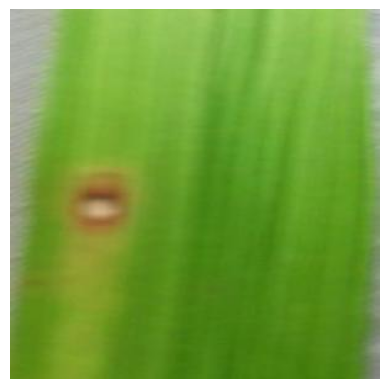

In [3]:
blast_image = cv2.imread('/kaggle/input/rice-leaf-disease-image/Blast/BLAST1_001.jpg')
print('image_size: ', blast_image.shape)
plt.imshow(cv2.cvtColor(blast_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

image_size:  (300, 300, 3)


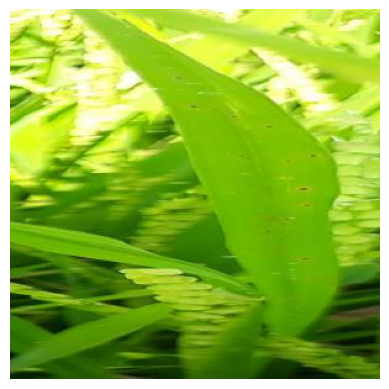

In [4]:
brownspot_image = cv2.imread('/kaggle/input/rice-leaf-disease-image/Brownspot/BROWNSPOT1_001.jpg')
print('image_size: ', brownspot_image.shape)
plt.imshow(cv2.cvtColor(brownspot_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [5]:
tungro_image = cv2.imread('/kaggle/input/rice-leaf-disease-image/Tungro/TUNGRO1_004.jpg')
print('image_size: ', tungro_image.shape)
plt.imshow(cv2.cvtColor(tungro_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

image_size:  (284, 214, 3)


Kích thước không đều nhau ở các lớp

# Tải dữ liệu

In [6]:
def load_data(data_dir):
    images_paths = []
    labels = []
    
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir):
            for image_file in os.listdir(label_dir):
                if image_file.lower().endswith('.jpg'):
                    images_paths.append(os.path.join(label_dir, image_file))
                    labels.append(label)
    
    return images_paths, labels

In [7]:
def show_sample_images(images_paths, labels, num_samples=12):
    """
    Hiển thị một số ảnh mẫu từ tập dữ liệu
    
    Args:
        images_paths: List các đường dẫn ảnh
        labels: List các nhãn tương ứng
        num_samples: Số lượng ảnh mẫu để hiển thị
    """
    plt.figure(figsize=(12, 12))
    
    # Chọn ngẫu nhiên một số ảnh
    sample_indices = random.sample(range(len(images_paths)), min(num_samples, len(images_paths)))
    
    for i, idx in enumerate(sample_indices):
        img = Image.open(images_paths[idx])
        plt.subplot(3, 4, i+1)
        plt.imshow(img)
        plt.title(f"Class: {labels[idx]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [8]:
data_dir = "/kaggle/input/rice-leaf-disease-image" 
    
images_paths, labels = load_data(data_dir)
print(f"Đã load {len(images_paths)} ảnh, {len(set(labels))} lớp")

Đã load 5932 ảnh, 4 lớp


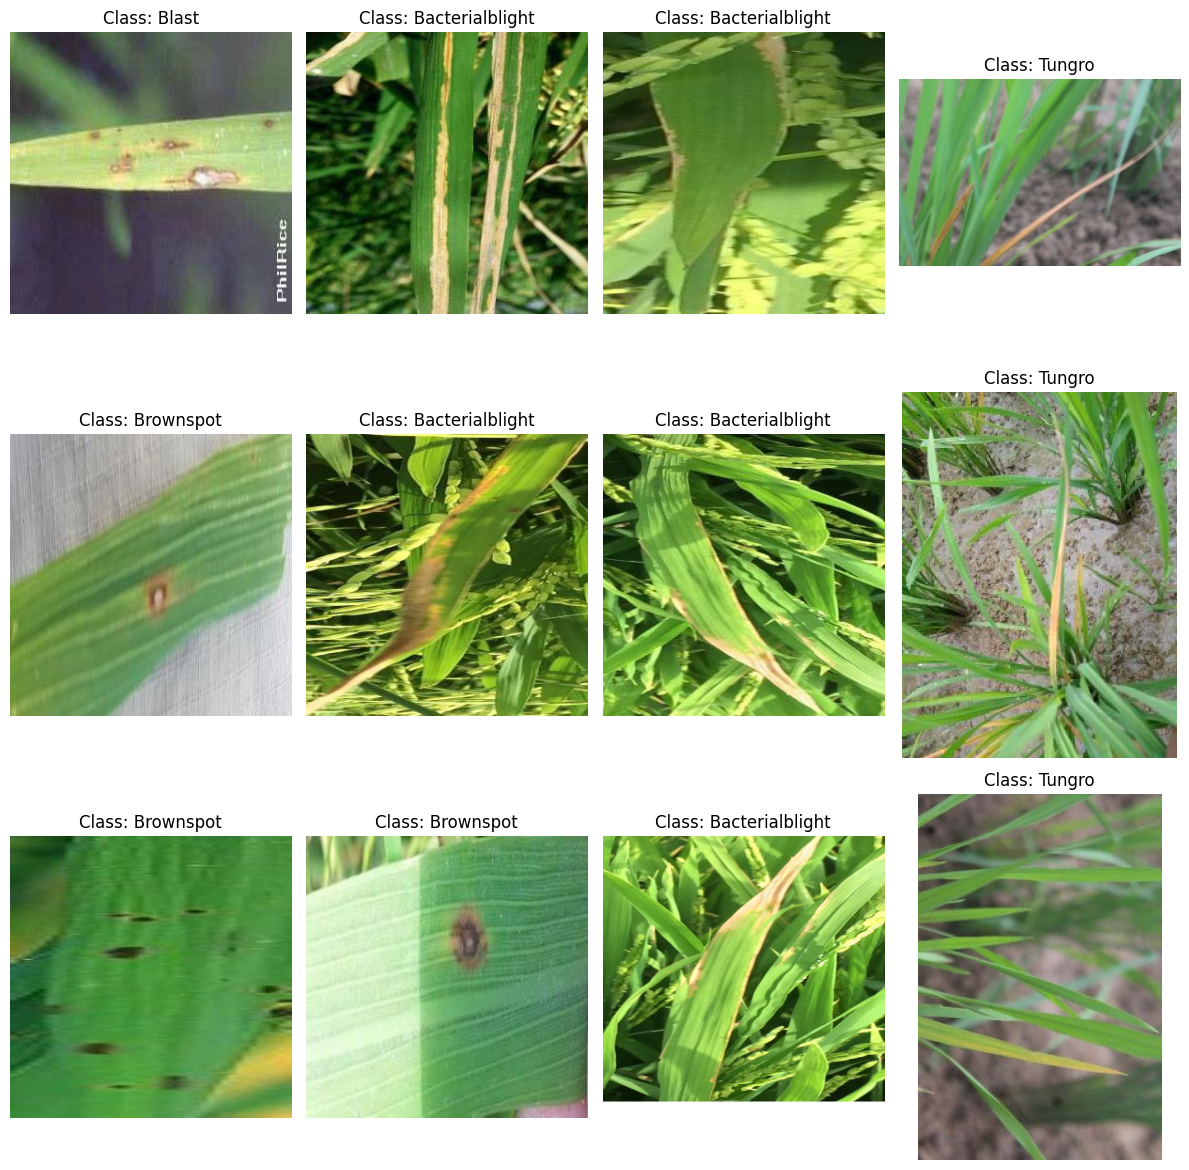

In [9]:
show_sample_images(images_paths, labels)

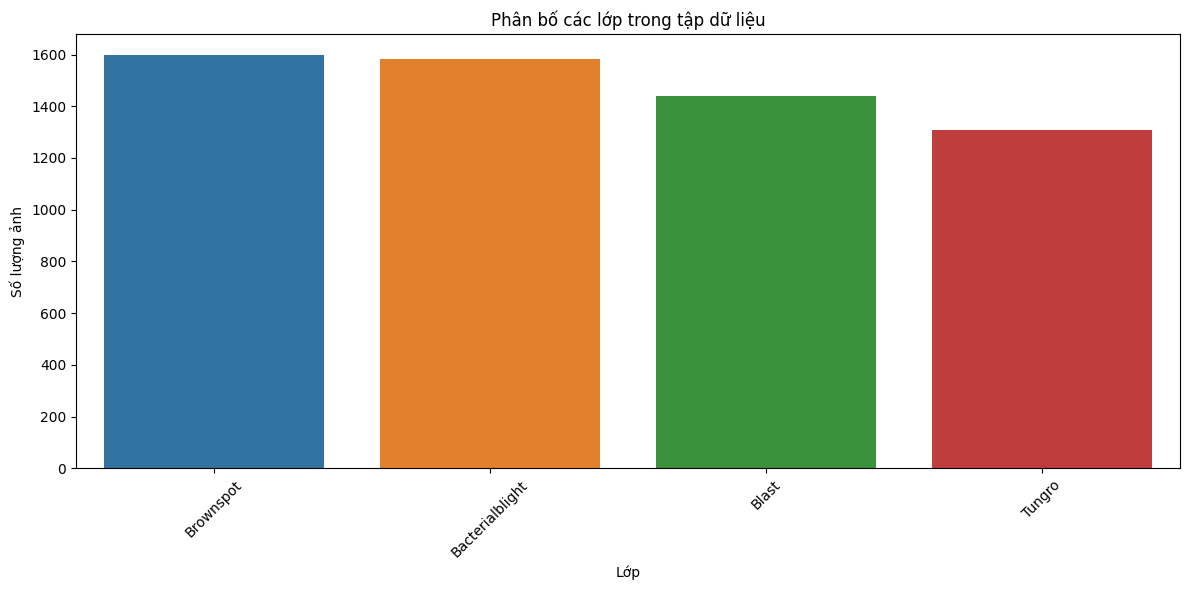

Phân bố lớp:
Brownspot: 1600 ảnh (26.97%)
Bacterialblight: 1584 ảnh (26.70%)
Blast: 1440 ảnh (24.28%)
Tungro: 1308 ảnh (22.05%)


In [10]:
def analyze_class_distribution(labels):
    
    class_counts = pd.Series(labels).value_counts()
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values)
    plt.title('Phân bố các lớp trong tập dữ liệu')
    plt.xlabel('Lớp')
    plt.ylabel('Số lượng ảnh')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print("Phân bố lớp:")
    for cls, count in class_counts.items():
        print(f"{cls}: {count} ảnh ({count/len(labels)*100:.2f}%)")

analyze_class_distribution(labels)

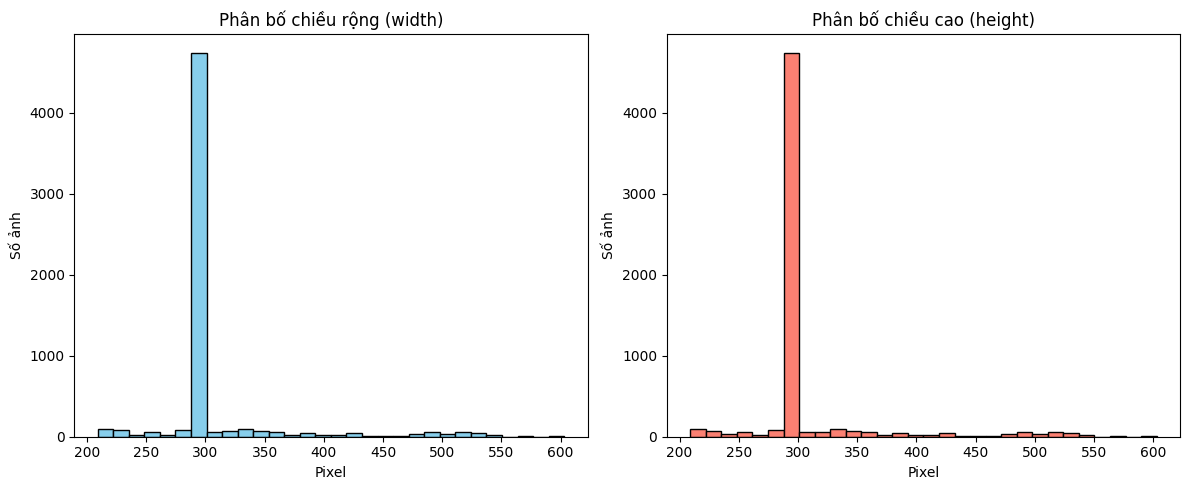

Số ảnh: 5932
Chiều rộng - min: 209, max: 603, trung bình: 312
Chiều cao  - min: 209, max: 603, trung bình: 312


In [11]:
def visualize_image_size_distribution(image_paths):
    widths = []
    heights = []

    for path in image_paths:
        try:
            with Image.open(path) as img:
                w, h = img.size
                widths.append(w)
                heights.append(h)
        except:
            print(f"Error loading image: {path}")

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=30, color='skyblue', edgecolor='black')
    plt.title("Phân bố chiều rộng (width)")
    plt.xlabel("Pixel")
    plt.ylabel("Số ảnh")

    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=30, color='salmon', edgecolor='black')
    plt.title("Phân bố chiều cao (height)")
    plt.xlabel("Pixel")
    plt.ylabel("Số ảnh")

    plt.tight_layout()
    plt.show()

    print(f"Số ảnh: {len(image_paths)}")
    print(f"Chiều rộng - min: {min(widths)}, max: {max(widths)}, trung bình: {sum(widths)//len(widths)}")
    print(f"Chiều cao  - min: {min(heights)}, max: {max(heights)}, trung bình: {sum(heights)//len(heights)}")


visualize_image_size_distribution(images_paths)

In [12]:
img = cv2.imread(images_paths[0])
print(img.dtype) 

uint8


In [13]:
IMAGE_SIZE = 224

def preprocess_image(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img = cv2.resize(img, target_size)
    
    img = img.astype('float32') / 255.0
    
    return img

In [14]:
SEED = 42

def split_data(images_paths, labels, val_size=0.25):
    
    # Chia tập train và test
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        images_paths, labels, test_size=val_size, stratify=labels, random_state=SEED
    )
    
    
    print(f"Tập huấn luyện: {len(train_paths)} ảnh")
    print(f"Tập xác thực: {len(val_paths)} ảnh")
    
    return train_paths, train_labels, val_paths, val_labels

In [15]:
train_paths, train_labels, val_paths, val_labels = split_data(images_paths, labels)

Tập huấn luyện: 4449 ảnh
Tập xác thực: 1483 ảnh


In [16]:
BATCH_SIZE = 32

def create_data_generators(train_paths, train_labels, val_paths, val_labels):
    
    # Ánh xạ nhãn văn bản thành số nguyên
    unique_labels = sorted(set(train_labels))
    label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
    
    # Chuyển đổi nhãn văn bản sang số nguyên
    train_labels_idx = [label_to_idx[label] for label in train_labels]
    val_labels_idx = [label_to_idx[label] for label in val_labels]
    
    # Tạo augmentation cho tập huấn luyện
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Không augmentation cho tập validation và test
    val_datagen = ImageDataGenerator()
    
    # Tạo các generator
    # Xây dựng hàm tạo dữ liệu
    def generate_data(paths, labels, batch_size, datagen, shuffle=True):
        num_samples = len(paths)
        while True:
            if shuffle:
                # Xáo trộn dữ liệu
                idx = np.random.permutation(num_samples)
                paths = [paths[i] for i in idx]
                labels = [labels[i] for i in idx]
            
            for start_idx in range(0, num_samples, batch_size):
                end_idx = min(start_idx + batch_size, num_samples)
                batch_paths = paths[start_idx:end_idx]
                batch_labels = labels[start_idx:end_idx]
                
                # Đọc và tiền xử lý ảnh
                batch_images = np.array([preprocess_image(path) for path in batch_paths])
                batch_labels_encoded = np.array(batch_labels)
                
                # Áp dụng augmentation
                if datagen is not None:
                    for x_batch, y_batch in datagen.flow(batch_images, batch_labels_encoded, batch_size=len(batch_images)):
                        yield x_batch, y_batch
                        break
                else:
                    yield batch_images, batch_labels_encoded
    
    train_gen = generate_data(train_paths, train_labels_idx, BATCH_SIZE, train_datagen)
    val_gen = generate_data(val_paths, val_labels_idx, BATCH_SIZE, None, shuffle=False)
    
    return train_gen, val_gen, label_to_idx


train_gen, val_gen, label_to_idx = create_data_generators(
        train_paths, train_labels, val_paths, val_labels
    )

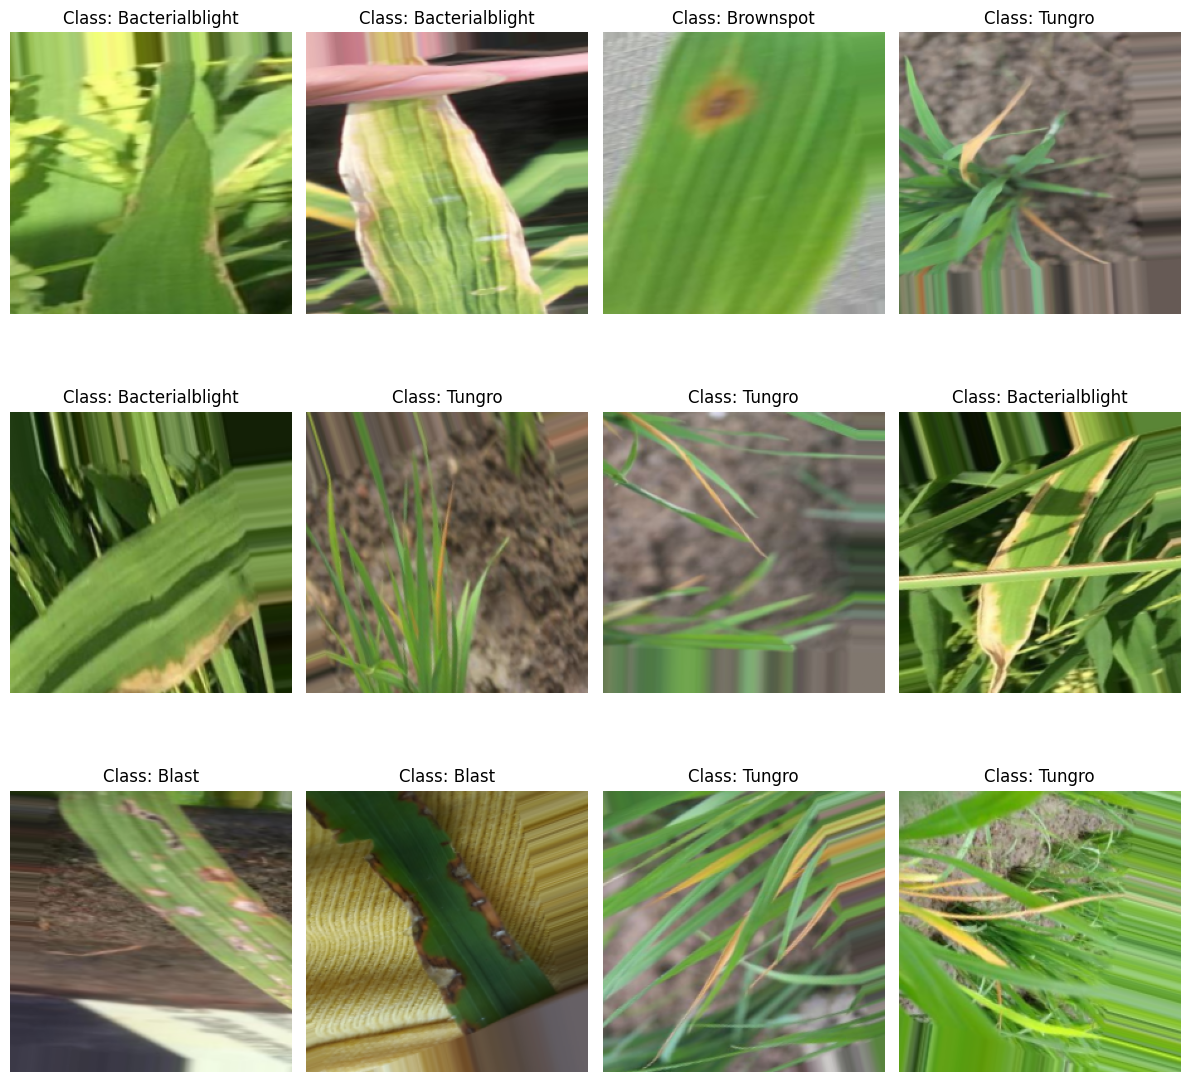

In [17]:
def show_augmented_batch(data_generator, label_to_idx):
    idx_to_label = {idx: label for label, idx in label_to_idx.items()}
    
    # Lấy một batch dữ liệu
    images, labels = next(data_generator)
    
    plt.figure(figsize=(12, 12))
    for i in range(min(12, len(images))):
        plt.subplot(3, 4, i+1)
        plt.imshow(images[i])
        plt.title(f"Class: {idx_to_label[labels[i]]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

show_augmented_batch(train_gen, label_to_idx)

In [18]:
def plot_training_history(history):

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Huấn luyện mô hình

## 1. Mô hình CNN cơ bản

In [19]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model_cnn = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=11,strides=3, input_shape=[IMAGE_SIZE, IMAGE_SIZE, 3]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=4, activation='softmax'),
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1747757220.653143      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [20]:
model_cnn.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [21]:
model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 75, 75, 64)          │          23,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 18, 18, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,654,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,792,836 (14.47 MB)

 Trainable params: 3,792,836 (14.47 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
EPOCHS = 40

checkpoint = ModelCheckpoint(
        'bestmodel_cnn.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1
    )
early_stopping = EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
    )
reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1
    )
    
steps_per_epoch = len(train_paths) // BATCH_SIZE
validation_steps = len(val_paths) // BATCH_SIZE
    
steps_per_epoch = max(1, steps_per_epoch)
validation_steps = max(1, validation_steps)
    
history = model_cnn.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS,
        validation_data=val_gen,
        validation_steps=validation_steps,
        callbacks=[checkpoint, early_stopping, reduce_lr]
    )

Epoch 1/40


I0000 00:00:1747757227.705439     106 service.cc:148] XLA service 0x7f078c0148d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747757227.706194     106 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747757228.155361     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/139 ━━━━━━━━━━━━━━━━━━━━ 24:21 11s/step - accuracy: 0.3750 - loss: 1.3817

I0000 00:00:1747757233.476981     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.2739 - loss: 1.3991
Epoch 1: val_accuracy improved from -inf to 0.45516, saving model to bestmodel_cnn.h5
139/139 ━━━━━━━━━━━━━━━━━━━━ 81s 508ms/step - accuracy: 0.2741 - loss: 1.3988 - val_accuracy: 0.4552 - val_loss: 1.1785 - learning_rate: 0.0010
Epoch 2/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.3939 - loss: 1.2809
Epoch 2: val_accuracy improved from 0.45516 to 0.59171, saving model to bestmodel_cnn.h5
139/139 ━━━━━━━━━━━━━━━━━━━━ 68s 489ms/step - accuracy: 0.3942 - loss: 1.2804 - val_accuracy: 0.5917 - val_loss: 1.0797 - learning_rate: 0.0010
Epoch 3/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.3443 - loss: 1.3126
Epoch 3: val_accuracy did not improve from 0.59171
139/139 ━━━━━━━━━━━━━━━━━━━━ 67s 484ms/step - accuracy: 0.3446 - loss: 1.3123 - val_accuracy: 0.4429 - val_loss: 1.1276 - learning_rate: 0.0010
Epoch 4/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.4300 - loss: 1.2226
E

In [23]:
plot_training_history(history)